In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import re,nltk,json
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import models
from keras import layers
from tensorflow.keras.layers import LSTM,GRU
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
from sklearn.metrics import average_precision_score,roc_auc_score, roc_curve, precision_recall_curve
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
np.random.seed(42)
class color: # Text style
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [2]:
from google.colab import drive
drive.mount('/content/drive')
from google.colab import data_table
data_table.enable_dataframe_formatter()

Mounted at /content/drive


# Read CSV

In [26]:
data = pd.read_csv('/content/drive/MyDrive/NewsData/news_classification_new.csv',encoding='utf-8')

In [28]:
data.count()

headline          130093
category          130096
newspaper name    130096
dtype: int64

# Data Stat

Total number of headlines: 130096


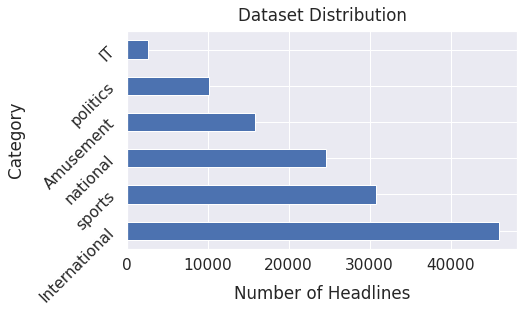

In [29]:
print(f'Total number of headlines: {len(data)}')
sns.set(font_scale=1.4)
data['category'].value_counts().plot(kind='barh', figsize=(7, 4))
plt.xlabel("Number of Headlines", labelpad=12)
plt.ylabel("Category", labelpad=12)
plt.yticks(rotation = 45)
plt.title("Dataset Distribution", y=1.02);

In [6]:
#data= data.drop_duplicates()

In [7]:
#data.to_csv("/content/drive/MyDrive/NewsData/news_classification_new.csv",index=False)

In [8]:
#data = pd.read_csv('/content/drive/MyDrive/NewsData/news_classification_new.csv',encoding='utf-8')

In [30]:
class_count = data.groupby('category').count()
class_count

,headline,newspaper name
category,,
Amusement,15820,15820
IT,2665,2665
International,45954,45955
national,24622,24622
politics,10202,10202
sports,30830,30832


In [32]:
      ## separating data based on category
      # --------------------------------- #

# IT
it = data['category'].values == 'IT'
dataIT = data[it].reset_index(drop=True)
IT_headline = dataIT['headline']
#IT_headline

# Augmentation on IT class

In [8]:
%%capture
!pip install transformers
!pip3 install nlpaug

In [ ]:
from transformers import *
import nlpaug.augmenter.word.context_word_embs as aug
augmenter = aug.ContextualWordEmbsAug(model_path='csebuetnlp/banglabert_generator', action="substitute")

In [10]:
txt= augmenter.augment(IT_headline[2])
listToStr = ' '.join([str(elem) for elem in txt])
#dataIT['headline'][0]
print('Original Text: ', IT_headline[2])
print('Augmented Text: ', listToStr)

Original Text:  ন্যাশনাল আইসিটি অ্যাওয়ার্ড পেল ‘হ্যালো ডক্টর এশিয়া’
Augmented Text:  ন্যাশনাল আইসিটি [UNK] পেল [UNK] একজন ডক্টর কে ধন্যবাদ


In [11]:
augmentedDf = pd.DataFrame(columns=["headline", "category"])
for i in range(len(IT_headline)):
  for j in range(4): #The number of new sentecnce you want to generate
    txt= augmenter.augment(IT_headline[i]) #Pass the column of the dataframe containing sentences
    augStr = ' '.join([str(elem) for elem in txt])
    print(i)
    print(augStr)
    augmentedDf = augmentedDf.append({'headline':augStr, 'category': 'IT', 'newspaper name': 'augmented'}, ignore_index=True)

Streaming output truncated to the last 5000 lines.
2040
আর চুরি হয়েছে তার ফেসবুক প্রোফাইল থেকেও
2040
এতে চুরি যাবে আপনার ফেসবুক প্রোফাইল ।
2040
আর পাওয়া যাবে না হরিণ প্রতীকী ছবি
2040
আর চেনা যাবে না অন্যের প্রোফাইল পাসওয়ার্ড
2041
সফর থেকে কেন সরে যাচ্ছে সাকিবের বন্ধুটি?
2041
ফেসবুক থেকে এভাবে হারিয়ে যাচ্ছে কিশোর মানুষ?
2041
জীবন থেকে কোথায় সরে গেল কিশোর তরুণরা?
2041
সমাজ থেকে কেন দূরে যাচ্ছে কিশোর বন্ধু?
2042
বিসিবি লোগোতে স্বাক্ষর
2042
নতুন দিনে ফুল
2042
সাতক্ষীরার মুখ ফেসবুক
2042
নিজের লোগোতে বাংলাদেশ
2043
কাশ্মীর ইস্যুতে জাতিসংঘে ট্রাম্পের প্রস্তাবে জাকারবার্গের জবাব
2043
ফেসবুক ভেঙে দিলেও ট্রাম্পের প্রস্তাবে ভারতের হাত
2043
ফেসবুক ভেঙে দিতে ভারতীয় ষড়যন্ত্রের স্পষ্ট জবাব
2043
চেহারা বদলে দিতে মার্কিন প্রস্তাবে জাকারবার্গের জবাব
2044
[UNK] ইউটিউব ভিডিও মালিক হলেন সোহাগ ।
2044
[UNK] প্রধান ব্র্যান্ড অ্যাম্বাসেডর হলেন পরিচালক রনি
2044
[UNK] ইউটিউব ইভেন্ট ম্যানেজার হলেন জয় [UNK]
2044
[UNK] বাংলাদেশের ব্র্যান্ড কোচ হলেন সোহাগ ভূঁইয়া
2045
বিনোদন [UNK] ফেসবুক পেজ
2045
কঠিন [UNK] স

In [12]:
augmentedDf

,headline,category,newspaper name
0,মাইক্রোসফট মিউজিক লাইভ সামিট,IT,augmented
1,মাইক্রোসফট লিমিটেডের বাংলা অভিধান,IT,augmented
2,মাইক্রোসফট [UNK] ফেসবুক সংস্করণ,IT,augmented
3,অবশেষে [UNK] সফটওয়্যার সামিট,IT,augmented
4,বিনামূল্যে ইন্টারনেট চায় শিক্ষার্থীদের [UNK] ...,IT,augmented
...,...,...,...
10655,১৬ দিনে তিন [UNK] স্টার্টক্যাম্প ২. ৭ এস,IT,augmented
10656,বিয়ের বিজ্ঞাপন ইউটিউব পেজ থেকে সতর্ক থাকতে বল...,IT,augmented
10657,[UNK] ওয়েবসাইট ও পেজ ব্যবহারে সতর্ক থাকতে বলল...,IT,augmented
10658,ইউটিউবে বিজ্ঞাপন ও পেজ পাঠাতে সতর্ক থাকতে বললো...,IT,augmented


In [13]:
#Save the new data
augmentedDf.to_csv("/content/drive/MyDrive/NewsData/IT_augmented.csv",index=False)

In [34]:
aug_IT = pd.read_csv('/content/drive/MyDrive/NewsData/IT_augmented.csv',encoding='utf-8')
aug_IT.count()

headline          10660
category          10660
newspaper name    10660
dtype: int64

In [35]:
type(data)

pandas.core.frame.DataFrame

In [36]:
type(aug_IT)

pandas.core.frame.DataFrame

In [37]:
Finaldata = pd.concat([aug_IT, data], axis=0)

In [40]:
Finaldata.to_csv("/content/drive/MyDrive/NewsData/News_headline_dataset_augmented.csv",index=False)

In [41]:
data_aug = pd.read_csv('/content/drive/MyDrive/NewsData/News_headline_dataset_augmented.csv',encoding='utf-8')

In [42]:
class_count = data_aug.groupby('category').count()
class_count

,headline,newspaper name
category,,
Amusement,15820,15820
IT,13325,13325
International,45954,45955
national,24622,24622
politics,10202,10202
sports,30830,30832


Total number of headlines: 140756


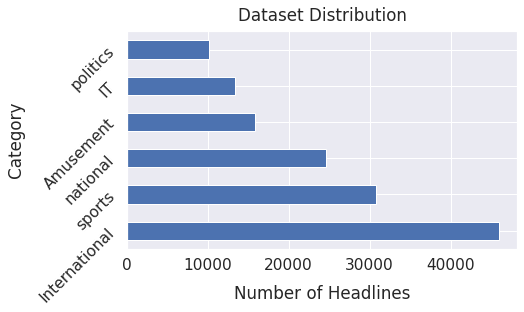

In [43]:
print(f'Total number of headlines: {len(data_aug)}')
sns.set(font_scale=1.4)
data_aug['category'].value_counts().plot(kind='barh', figsize=(7, 4))
plt.xlabel("Number of Headlines", labelpad=12)
plt.ylabel("Category", labelpad=12)
plt.yticks(rotation = 45)
plt.title("Dataset Distribution", y=1.02);

In [45]:
data_aug.count()

headline          140753
category          140756
newspaper name    140756
dtype: int64